In [16]:
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import pandas as pd
from sklearn.preprocessing import LabelEncoder as le

In [17]:
df_raw = pd.read_excel("output/resampled_df_10_min.xlsx", index_col=[0])

In [18]:
start_date = pd.to_datetime(f"2022-01-10 00:00:00")
end_date = pd.to_datetime(f"2022-05-01 23:50:00")
training_window_size = 60
horizon_size = 14
model_features = ["day", "hour", "weekday"]

In [19]:
df = df_raw[df_raw["time"].between(start_date, end_date)].copy()

label_encoder = le()
df.location = label_encoder.fit_transform(df.location)

In [20]:
df["weekday"] = df["time"].dt.dayofweek
df["hour"] = df["time"].dt.hour
df["day"] = df["time"].dt.day

In [21]:
train_start_date = start_date
train_end_date = train_start_date + pd.Timedelta(days=training_window_size-1, hours=23, minutes=50)
test_start_date = train_end_date + pd.Timedelta(minutes=10)
test_end_date = test_start_date + pd.Timedelta(days=horizon_size-1, hours=23, minutes=50)

train_mask = df["time"].between(train_start_date, train_end_date)
test_mask = df["time"].between(test_start_date, test_end_date)

# Split the data into train and test sets
X_train = df.loc[train_mask, model_features]
y_train = df.loc[train_mask, "location"]
X_test = df.loc[test_mask, model_features]
y_test = df.loc[test_mask, "location"]

print(f"Training: {train_start_date}-{train_end_date}, testing: {test_start_date}-{test_end_date}.")

Training: 2022-01-10 00:00:00-2022-03-10 23:50:00, testing: 2022-03-11 00:00:00-2022-03-24 23:50:00.


In [22]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions for 14 days into the future. 
predictions = model.predict(X_test) # Or use predict_proba

In [23]:
print(accuracy_score(y_test, predictions))

0.5119047619047619


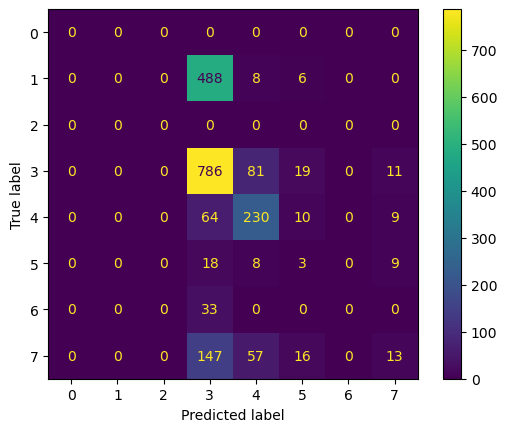

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [26]:
df.location = label_encoder.inverse_transform(df.location)
df.head()

,time,location,weekday,hour,day
1296,2022-01-10 00:00:00,"Florijn, 39",0,0,10
1297,2022-01-10 00:10:00,"Florijn, 39",0,0,10
1298,2022-01-10 00:20:00,"Florijn, 39",0,0,10
1299,2022-01-10 00:30:00,"Florijn, 39",0,0,10
1300,2022-01-10 00:40:00,"Florijn, 39",0,0,10


In [30]:
from Visualisations import HeatmapVisualizer


time_intervals = pd.date_range(
    start=test_start_date, end=test_end_date, freq="10T"
)

# Create a DataFrame with the 'time' column and the 'location' column that holds the predicted locations (strings).
df_predictions = pd.DataFrame(
    {
        "time": time_intervals,
        "location": label_encoder.inverse_transform(predictions),
    }
)

# Visualize the predictions in a heatmap and save it as heatmap_predicted.png.
HeatmapVisualizer(
    str(test_start_date.date()),
    str(test_end_date.date()),
    df_predictions,
    name="heatmap_predicted",
    title="PREDICTIONS"
)

# And also visualize the actual values in a heatmap named heatmap_actual.png
HeatmapVisualizer(
    str(test_start_date.date()),
    str(test_end_date.date()),
    df.loc[test_mask][["location", "time"]],  # Now we use the original dataframe (with time and location, 10 min intervals) to visualize the actual data.
    name="heatmap_actual",
    title="ACTUAL"
)

# And lastly, visualize the training data as well as heatmap_training.png.
HeatmapVisualizer(
    str(train_start_date.date()),
    str(train_end_date.date()),
    df.loc[train_mask][["location", "time"]],  # Now we use the original dataframe (with time and location, 10 min intervals) to visualize the actual data.
    name="heatmap_training",
    title="TRAINING"
)

TypeError: __init__() got an unexpected keyword argument 'title'